In [1]:
using Knet
using AutoGrad
using Images
using ImageMagick
using Random
using PyPlot
using Statistics
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using IterTools: ncycle, takenth
import CUDA
import Knet.Ops20: conv4x
include("layers.jl")
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

┌ Info: Precompiling Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1278


KnetArray{Float32,N} where N

Start by loading list of images to be used

In [2]:
dataset = load("dataset//singleObjects64Array.jld", "data");

In [3]:
dataTrn = convert(array_type, dataset);

Create iterator for Clevr Dataset

In [4]:
struct ClevrData
    images
    batchsize::Int
    num_instances::Int

    function ClevrData(dataset; batchsize::Int=32) #shuffle::Bool=false)
        nFullBatches, rem = divrem(size(dataTrn)[end], batchsize)
        new(dataset[:,:,:,1:nFullBatches*batchsize], batchsize, nFullBatches*batchsize)
    end
end

In [5]:
function length(d::ClevrData)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

length (generic function with 222 methods)

In [6]:
function iterate(d::ClevrData, state=collect(1:d.num_instances))
    if length(state) > 0
        batch = d.images[:,:,:,state[1:(length(state) < d.batchsize ? end : d.batchsize)]]
        state  = state[d.batchsize+1:end]
        return (Param(batch)), state
    end
end

iterate (generic function with 438 methods)

In [7]:
function dAccuracy(G, D, z, real)
    fake = G(z)
    fakePred = sum((D(fake) .< 0.5) .== 1)
    truePred = sum((D(real) .> 0.5) .== 1)
    accuray = (fakePred + truePred)/(2*size(real)[end])
end

dAccuracy (generic function with 1 method)

In [161]:
function dAccFake(G, D, z)
    fake = G(z)
    fakePred = sum((D(fake) .< 0) .== 1)
    accuray = (fakePred )/(size(fake)[end])
end

dAccFake (generic function with 1 method)

In [162]:
function dAccReal(D, real_img)
    truePred = sum((D(real_img) .> 0) .== 1)
    accuray = truePred/(size(real_img)[end])
end

dAccReal (generic function with 1 method)

In [10]:
function l2_norm(v, eps=1e-12)
    v ./ (sum(v.^2).^0.5+eps)
end

l2_norm (generic function with 2 methods)

In [13]:
# struct Scene
#     FG
#     BG
#     batchSize
#     bdim
#     fdim
#     function Scene(b::Int,f::Int,batchSize::Int)
#         FG = Chain(Deconv4(3,3,3,128,f,8,batchSize), Deconv4(3,3,3,64,128,16,batchSize))
#         BG = Chain(Deconv4(3,3,3,128,b,8,batchSize), Deconv4(3,3,3,64,128,16,batchSize))
#         new(FG,BG,batchSize,b,f)
#     end
# end

# function (s::Scene)()
#     print("Self noise Generate")
#     bt = Z4(4,4,4,s.bdim,s.batchSize)
#     ft = Z4(4,4,4,s.fdim,s.batchSize)
#     f = s.FG(ft)
#     g = s.BG(bt)
#     m  = max.(f, g)
#     concat = reshape(m, (16,16,16*64,:))
# end
# function (s::Scene)(bt,ft)
#     f = s.FG(ft)
#     g = s.BG(bt)
#     m  = max.(f, g)
#     concat = reshape(m, (16,16,16*64,:))
# end

In [11]:
struct HoloScene
    learntConst
    upconv1
    upconv2
    batchSize
    imSize
    zMapper1
    zMapper2
    zMapper3
    repeatHelper
    function HoloScene(imSize::Int, batchSize::Int, zDim::Int)
        learntConst = Param(param(4,4,4,imSize*8,1, init=gaussian) .* 2)
        upconv1 = Deconv4(3,3,3,128,imSize*8,8,batchSize)
        upconv2 = Deconv4(3,3,3,64,imSize*2,16,batchSize)
        zMap1 = ZMapper(zDim, imSize*8) 
        zMap2 = ZMapper(zDim, imSize*2)
        zMap3 = ZMapper(zDim, imSize*1)
        tile = ones(4, 4, 4, imSize*8, batchSize)
        tile = convert(KnetArray{Float32}, tile)
        new(learntConst,upconv1,upconv2,batchSize,imSize,zMap1,zMap2,zMap3,tile)
    end
end

function (s::HoloScene)(z)
    w_tile = s.learntConst .* s.repeatHelper
    s0, b0 = s.zMapper1(z)
    h0 = AdaIN(w_tile, s0, b0)
    h0 = relu.(h0)
    
    h1 = s.upconv1(h0)
    s1, b1 = s.zMapper2(z)
    h1 = AdaIN(h1, s1, b1)
    h1 = relu.(h1)

    h2 = s.upconv2(h1)
    s2, b2 = s.zMapper3(z)
    h2 = AdaIN(h2, s2, b2)
    h2 = relu.(h2)
    
    concat = reshape(h2, (16,16,16*s.imSize,:))
end

In [14]:
struct Discriminator
    layers
    Discriminator(layers...) = new(layers)
end
function (model::Discriminator)(x)
    for l in model.layers
        x = l(x)
    end
    x
end

In [13]:
struct Generator
    scene
    upconv1
    upconv2
    upconv3
    upconv4
    zMapper1
    zMapper2
    imSize
    function Generator(zDim, bs, imSize)
        scene = HoloScene(imSize, bs, zdim)
        upconv1 = Deconv(1,1,16*imSize,16*imSize)
        upconv2 = Deconv2(4,4,4*imSize,16*imSize,identity)
        upconv3 = Deconv2(4,4,imSize,4*imSize,identity)
        upconv4 = Deconv3(5,5,3,imSize,identity)
        zMap1 = ZMapper(zDim, 4*imSize) 
        zMap2 = ZMapper(zDim, imSize)
    new(scene,upconv1,upconv2,upconv3,upconv4,zMap1,zMap2,imSize)
    end
end

function (model::Generator)(z)
    h2_2d = model.scene(z)
    h3 = model.upconv1(h2_2d)
    
    h4 = model.upconv2(h3)
    s4, b4 = model.zMapper1(z)
    h4  = AdaIN(h4, s4, b4)
    h4  = relu.(h4)
    
    h5 = model.upconv3(h4)
    s5, b5 = model.zMapper2(z)
    h5  = AdaIN(h5, s5, b5)
    h5  = relu.(h5)
    
    h6 = model.upconv4(h5)

    output = tanh.(h6)
end

In [134]:
function sigmoid_cross_entropy_with_logits(logits, labels)
    zero = zeros(size(logits)); zero = convert(array_type, zero)
    one = ones(size(logits)); one = convert(array_type, one)
    max.(logits, zero) .- (logits .* labels) .+ log.(one .+ exp.(.- abs.(logits)))
end

sigmoid_cross_entropy_with_logits (generic function with 1 method)

In [156]:
function gLoss(G::Generator, D::Discriminator, z)
    logits = D(G(z))'
    labels = ones(size(logits))
    labels = convert(array_type, labels)
    return mean(sigmoid_cross_entropy_with_logits(logits, labels))
end

gLoss (generic function with 1 method)

In [157]:
function dLoss(D::Discriminator, realIms, fakeIms)
    labelsReal = ones(size(realIms)[end],1)
    labelsReal = convert(array_type, labelsReal)
    labelsFake = zeros(size(realIms)[end],1)
    labelsFake = convert(array_type, labelsFake)
    realLoss = mean(sigmoid_cross_entropy_with_logits(D(realIms)', labelsReal))
    fakeLoss = mean(sigmoid_cross_entropy_with_logits(D(fakeIms)', labelsFake))
    return realLoss+fakeLoss
end

dLoss (generic function with 1 method)

In [163]:
Random.seed!(1234)
loss_g = []
loss_d = []
acc_d_real = []
acc_d_fake = []
bs = 32
zdim = 128
imsize = 64
clevrDataset = ClevrData(dataTrn, batchsize=bs)
G = Generator(zdim, bs, imsize)
D = Discriminator(Conv_spectral(5,5,3,64), Conv_spectral(5,5,64,128), InstanceNorm(128), Conv_spectral(5,5,128,256), InstanceNorm(256), Conv_spectral(5,5,256,512), InstanceNorm(512), Dense(4*4*512,1,identity))

Discriminator((Conv_spectral(P(KnetArray{Float32,4}(5,5,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), leakyRelu), Conv_spectral(P(KnetArray{Float32,4}(5,5,64,128)), P(KnetArray{Float32,4}(1,1,128,1)), leakyRelu), InstanceNorm(P(KnetArray{Float32,4}(1,1,128,1)), P(KnetArray{Float32,4}(1,1,128,1))), Conv_spectral(P(KnetArray{Float32,4}(5,5,128,256)), P(KnetArray{Float32,4}(1,1,256,1)), leakyRelu), InstanceNorm(P(KnetArray{Float32,4}(1,1,256,1)), P(KnetArray{Float32,4}(1,1,256,1))), Conv_spectral(P(KnetArray{Float32,4}(5,5,256,512)), P(KnetArray{Float32,4}(1,1,512,1)), leakyRelu), InstanceNorm(P(KnetArray{Float32,4}(1,1,512,1)), P(KnetArray{Float32,4}(1,1,512,1))), Dense(P(KnetArray{Float32,2}(1,8192)), P(KnetArray{Float32,1}(1)), identity)))

In [93]:
# Knet.save("HoloGAN_models//2Epochs.jld2", "Generator", G, "Discriminator", D)

In [23]:
for par in params(D)
    println(mean(par))
    println(std(par))
    println()
end

0.00024875827
0.010079567

0.0
0.0

-6.5079275e-6
0.009985494

0.0
0.0

0.9990172
0.01923213

0.0
0.0

-4.678564e-6
0.009998815

0.0
0.0

0.9974135
0.020130878

0.0
0.0

-9.329164e-6
0.009996182

0.0
0.0

0.99973285
0.020455578

0.0
0.0

-2.1890039e-5
0.015537576

0.0
NaN



In [24]:
for par in params(G)
    println(mean(par))
    println(std(par))
    println()
end

0.00010697105
0.019963628

-1.1028074e-5
0.010761401

0.0
0.0

2.1431913e-5
0.01962139

0.0
0.0

-5.629073e-5
0.02006073

0.0
0.0

6.332324e-5
0.02004738

0.0
0.0

-0.00015040016
0.020061659

0.0
0.0

5.9714416e-6
0.010001794

0.0
0.0

-4.472563e-7
0.010000584

0.0
0.0

2.7001879e-5
0.009994081

0.0
0.0

6.627729e-5
0.01009342

0.0
0.0

4.043434e-5
0.01997363

0.0
0.0

-0.00024669312
0.02020383

0.0
0.0



In [173]:
function main()
    i = 0
    for real_image in ncycle(clevrDataset, 20)
        bs = size(real_image)[end]
        z = Z_Sample(zdim,bs)
        if i % 25 == 0
            push!(loss_g, gLoss(G, D, z))
            push!(loss_d, dLoss(D, real_image, G(z)))
            print("$(i): GenLoss: ");print(loss_g[end])
            print("    DisLoss: ");print(loss_d[end])
            push!(acc_d_real, dAccReal(D, real_image))
            push!(acc_d_fake, dAccFake(G,D,z))
            print("    AccReal: ");print(acc_d_real[end])
            print("    AccFake: ");println(acc_d_fake[end])
        end
#         if i % 2 == 0
        adam!(dLoss, [(D, real_image, G(z))], gclip = 5, lr = 0.0001, beta1=0.5)#, params=params(D))
#         end
        adam!(gLoss, [(G, D, z)], params=params(G), gclip = 5, lr = 0.0001,beta1=0.5)
        adam!(gLoss, [(G, D, z)], params=params(G), gclip = 5, lr = 0.0001,beta1=0.5)
        i += 1
    end
end

main (generic function with 1 method)

In [182]:
main()

0: GenLoss: 3.18895    DisLoss: 0.16065042    AccReal: 1.0    AccFake: 0.9375
25: GenLoss: 3.551802    DisLoss: 0.20094228    AccReal: 1.0    AccFake: 1.0
50: GenLoss: 4.0400043    DisLoss: 0.17605357    AccReal: 1.0    AccFake: 0.9375
75: GenLoss: 4.5963526    DisLoss: 0.48389894    AccReal: 0.84375    AccFake: 0.96875
100: GenLoss: 2.5902228    DisLoss: 0.29139546    AccReal: 0.96875    AccFake: 0.90625
125: GenLoss: 1.7673085    DisLoss: 0.5334146    AccReal: 1.0    AccFake: 0.78125
150: GenLoss: 1.9618337    DisLoss: 0.40520135    AccReal: 1.0    AccFake: 0.875
175: GenLoss: 4.5680733    DisLoss: 0.2705138    AccReal: 0.84375    AccFake: 1.0
200: GenLoss: 4.524439    DisLoss: 0.25060022    AccReal: 0.9375    AccFake: 0.96875
225: GenLoss: 2.9050937    DisLoss: 0.35072473    AccReal: 0.875    AccFake: 1.0
250: GenLoss: 4.560843    DisLoss: 0.29058665    AccReal: 0.9375    AccFake: 1.0
275: GenLoss: 3.8046288    DisLoss: 0.5063014    AccReal: 0.8125    AccFake: 1.0
300: GenLoss: 1.66

LoadError: InterruptException:

In [59]:
lossPlot = plot([loss_g, loss_d],labels=["Gen" ,"Dis"],xlabel="Iters",ylabel="Loss");

LoadError: MethodError: no method matching *(::Type{Array{Float32,N} where N}, ::Array{Any,1})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::PyCall.PyObject, ::Any) at /kuacc/users/aanees20/.julia/packages/PyCall/BcTLp/src/pyoperators.jl:13
  *(!Matched::LinearAlgebra.Transpose{var"#s828",var"#s827"} where var"#s827"<:StridedArray{T, 2} where var"#s828", ::StridedArray{S, 1}) where {T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64}, S} at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/matmul.jl:84
  ...

In [ ]:
lossPlot = plot([acc_d_real, acc_d_fake],labels=["Real" ,"Fake"],xlabel="Iters",ylabel="Loss")

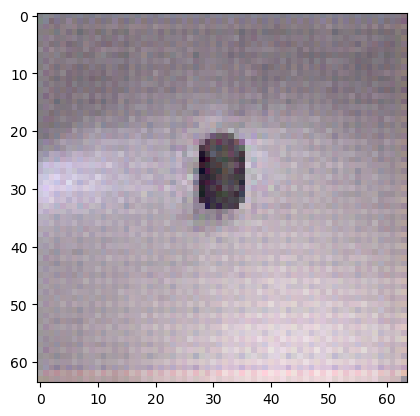

PyObject <matplotlib.image.AxesImage object at 0x2abf8a6ccef0>

In [192]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

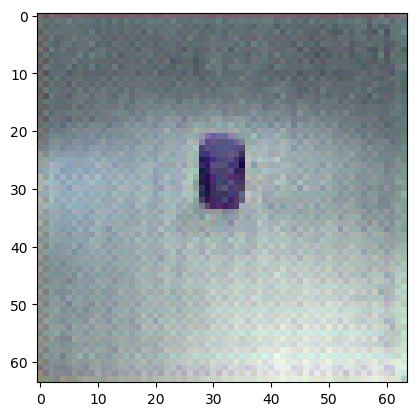

PyObject <matplotlib.image.AxesImage object at 0x2abf81aee940>

In [175]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

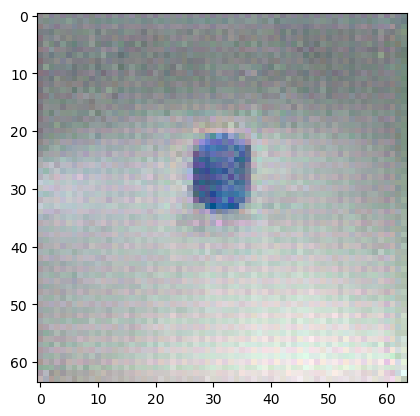

PyObject <matplotlib.image.AxesImage object at 0x2abf81b4fe80>

In [176]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

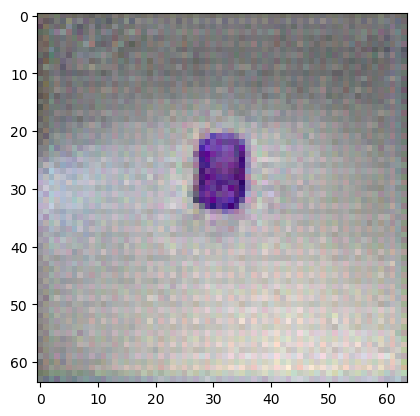

PyObject <matplotlib.image.AxesImage object at 0x2abf81d47940>

In [181]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

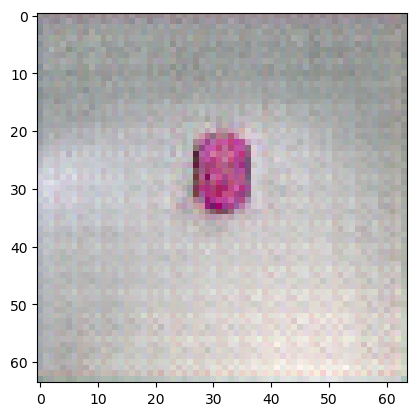

PyObject <matplotlib.image.AxesImage object at 0x2abf819d0128>

In [170]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

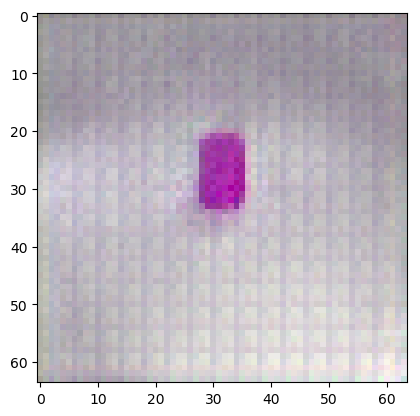

PyObject <matplotlib.image.AxesImage object at 0x2abf81a34668>

In [171]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

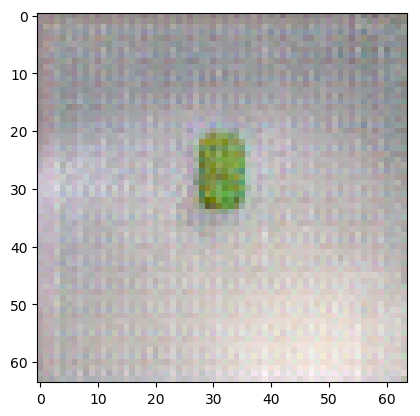

PyObject <matplotlib.image.AxesImage object at 0x2abf81a93ba8>

In [172]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

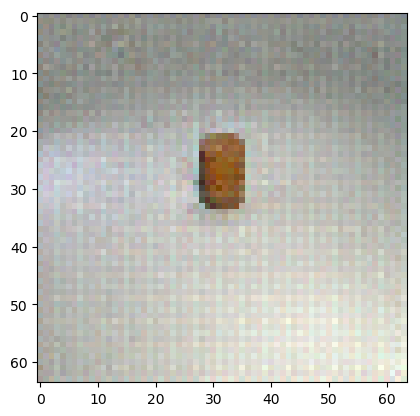

PyObject <matplotlib.image.AxesImage object at 0x2af13c688c18>

In [96]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

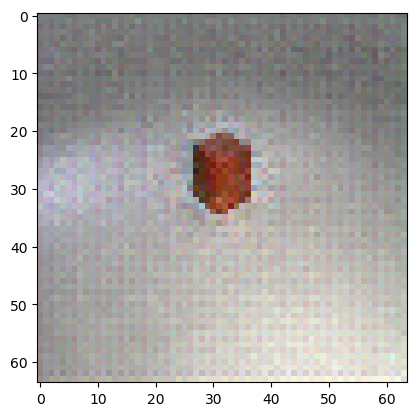

PyObject <matplotlib.image.AxesImage object at 0x2af13c7b5c18>

In [99]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

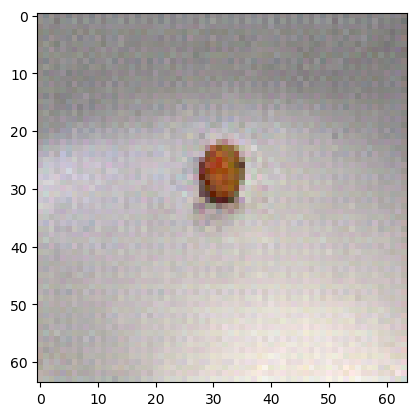

PyObject <matplotlib.image.AxesImage object at 0x2af13c25e5c0>

In [84]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

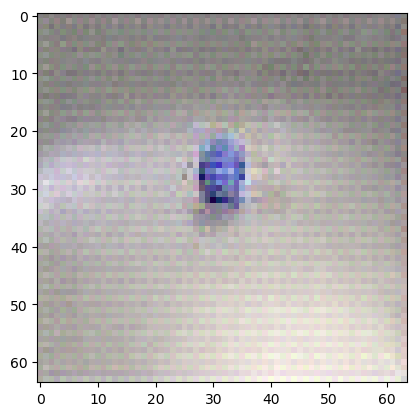

PyObject <matplotlib.image.AxesImage object at 0x2af13c32b080>

In [86]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

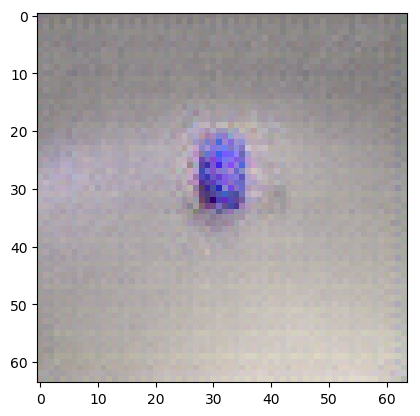

PyObject <matplotlib.image.AxesImage object at 0x2af13c38a5c0>

In [87]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

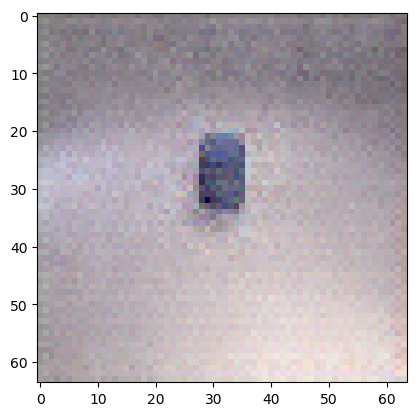

PyObject <matplotlib.image.AxesImage object at 0x2af13c3edb00>

In [88]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

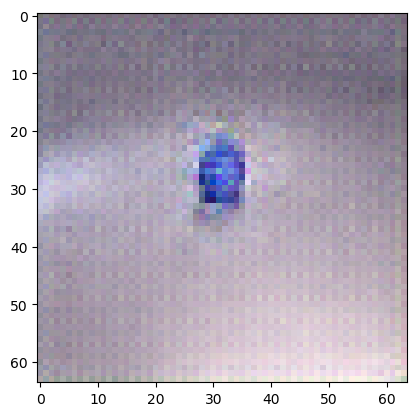

PyObject <matplotlib.image.AxesImage object at 0x2af13c441400>

In [89]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

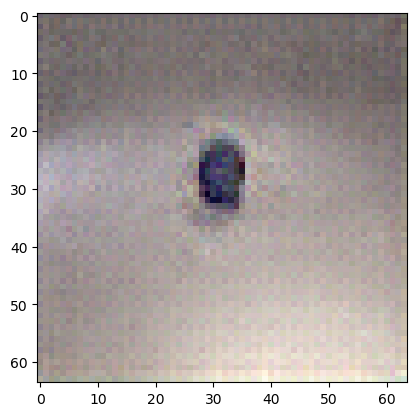

PyObject <matplotlib.image.AxesImage object at 0x2af13c4a1940>

In [90]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

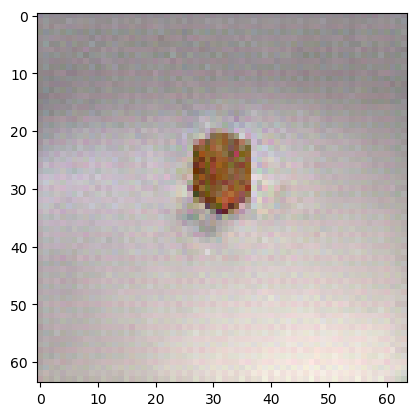

PyObject <matplotlib.image.AxesImage object at 0x2af13c501e80>

In [91]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

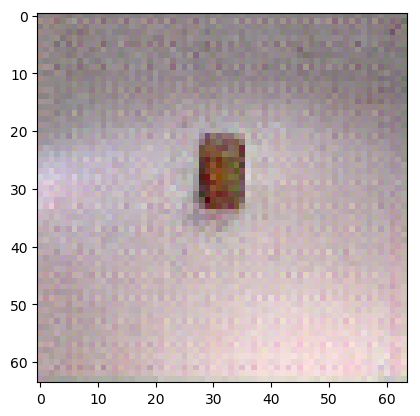

PyObject <matplotlib.image.AxesImage object at 0x2af13c56b400>

In [92]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

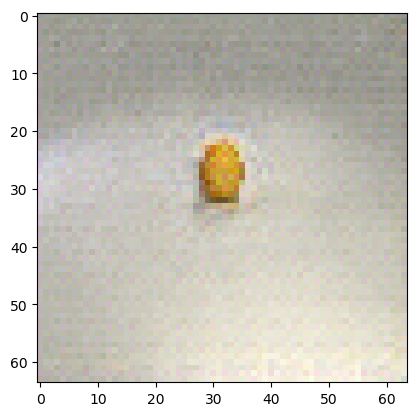

PyObject <matplotlib.image.AxesImage object at 0x2af13c5cc3c8>

In [93]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

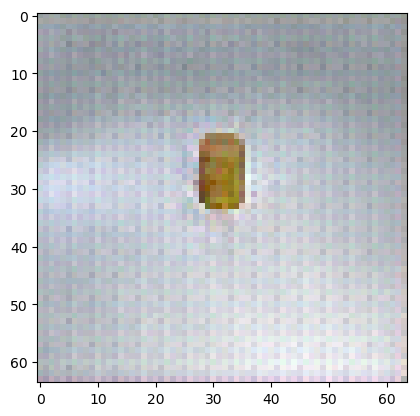

PyObject <matplotlib.image.AxesImage object at 0x2af13596bba8>

In [49]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

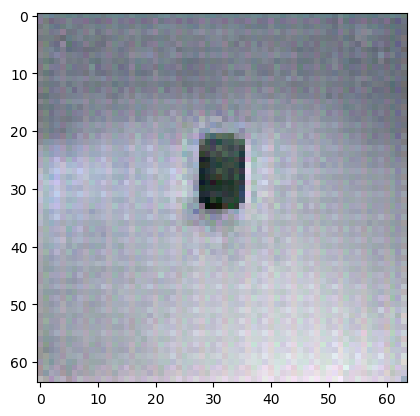

PyObject <matplotlib.image.AxesImage object at 0x2af1359c7dd8>

In [55]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

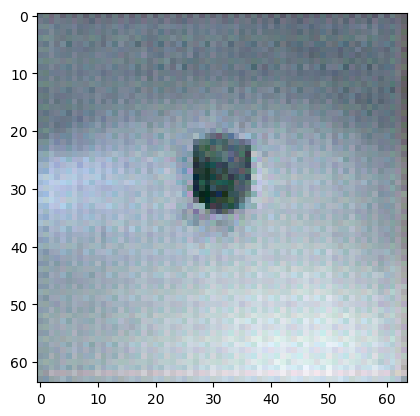

PyObject <matplotlib.image.AxesImage object at 0x2af135a33358>

In [56]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

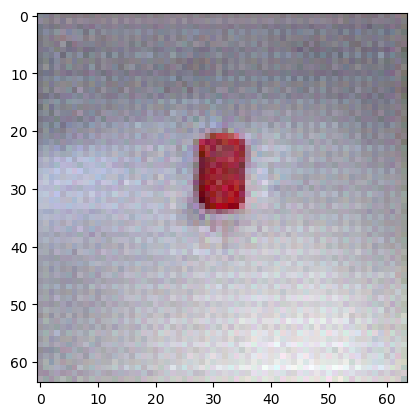

PyObject <matplotlib.image.AxesImage object at 0x2af135a92898>

In [57]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

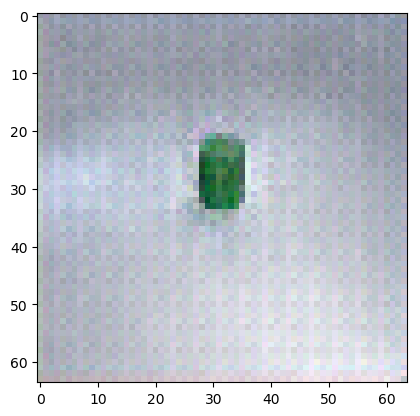

PyObject <matplotlib.image.AxesImage object at 0x2af135af3dd8>

In [58]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

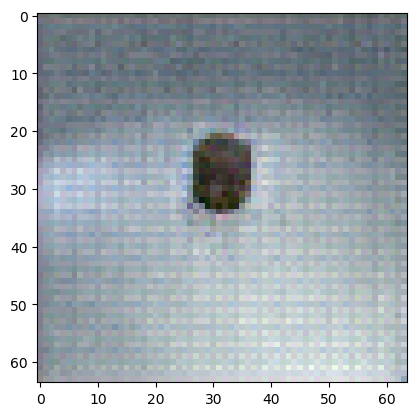

PyObject <matplotlib.image.AxesImage object at 0x2af135b60358>

In [59]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

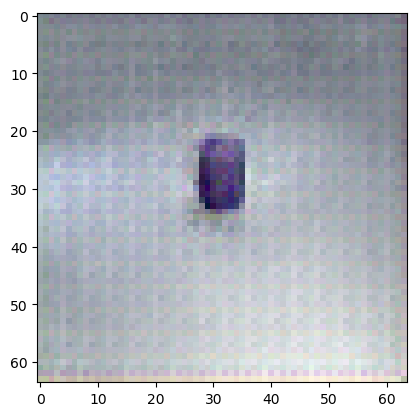

PyObject <matplotlib.image.AxesImage object at 0x2af135bbe898>

In [60]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

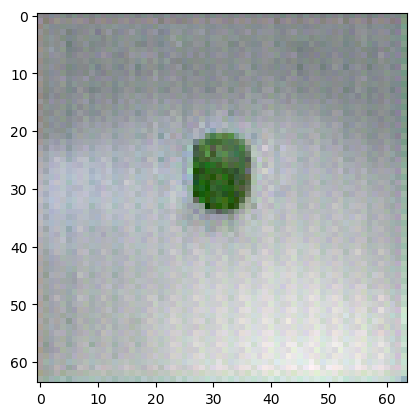

PyObject <matplotlib.image.AxesImage object at 0x2af135c21dd8>

In [61]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

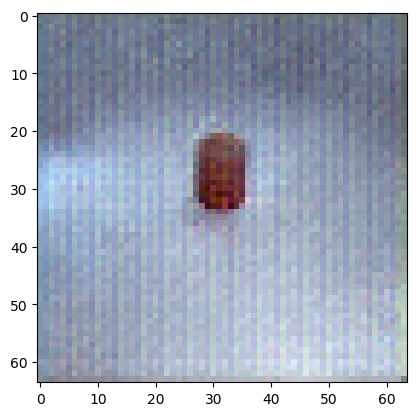

PyObject <matplotlib.image.AxesImage object at 0x2af135c81da0>

In [62]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

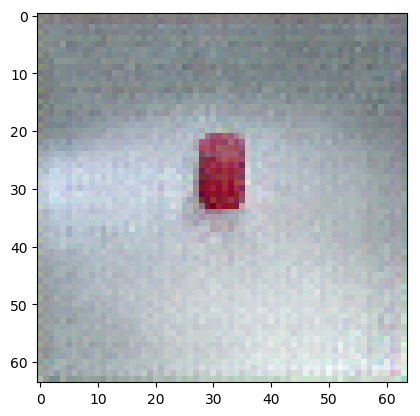

PyObject <matplotlib.image.AxesImage object at 0x2af135ced898>

In [63]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

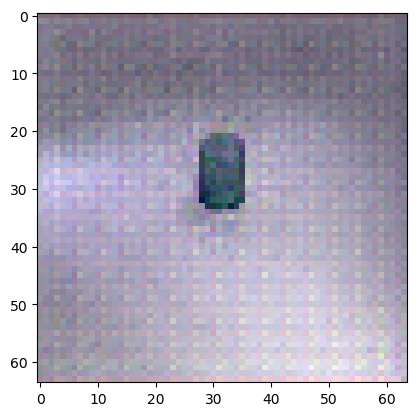

PyObject <matplotlib.image.AxesImage object at 0x2af135d4ddd8>

In [64]:
z = Z_Sample(zdim,1)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

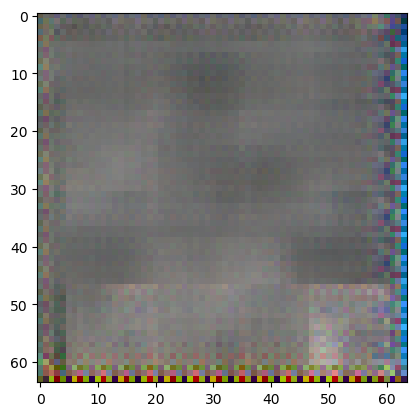

Self noise Generate

PyObject <matplotlib.image.AxesImage object at 0x2acffcef49b0>

In [99]:
img = G(1)[:,:,:,1]
img = convert(Array{Float32}, value(img))
imshow(img)

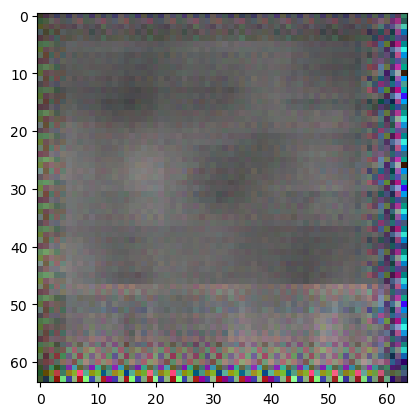

Self noise Generate

PyObject <matplotlib.image.AxesImage object at 0x2acffce965f8>

In [92]:
img = G(1)[:,:,:,1]
img = convert(Array{Float32}, value(img))
imshow(img)

In [75]:
# img = img ./ maximum(img, dims = 3);
# imshow(img);
# # img

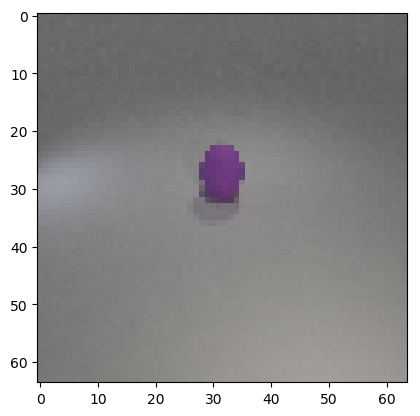

PyObject <matplotlib.image.AxesImage object at 0x2b49d2f05f28>

In [43]:
clevrDataset1 = ClevrData(singleObj)
img1= first(take(clevrDataset1, 1))[:,:,:,1]
img1 = convert(Array{Float32}, value(img1))
imshow(img1)

In [44]:
G(1)

LoadError: CUDNNError: CUDNN_STATUS_INTERNAL_ERROR (code 4)

In [45]:
D(first(take(clevrDataset1, 1)))

LoadError: CUDNNError: CUDNN_STATUS_INTERNAL_ERROR (code 4)

In [46]:
# a = param(16,16,1024,10)
# Deconv(1,1,64,16*64)(a)

In [47]:
# a = Deconv2(3,3,3,128,512)
# a(param(4,4,4,512,1))
# b = Deconv2(4,4,4,64,128)
# b(a(param(4,4,4,512,1)))

In [48]:
# background = ObjectGenerator()
# foreground = ObjectGenerator()
# composedScene = max.(background, foreground)
# concat = reshape(composedScene, (16,16,16*64,1))
# c1 = Conv(1,1,1024,64)
# projected = c1(concat)

In [45]:
# # bs = 32
# # a = Scene(256,512,bs)
# # # bt = Z4(4,4,4,256,32)
# # # a = Deconv4(3,3,3,128,f,8,32)
# bg = Z4(4,4,4,256,bs)
# fg = Z4(4,4,4,512,bs)
# z = (bg, fg)

# # a(bg, fg)
# # # ft = Z4(4,4,4,512,32)

# # w = param(3,3,3,128,512)
# # b=param0(1,1,1,128,1)
# # o=KnetArray{Float32}(undef,8, 8, 8, 128, 1)

# # out = conv4x(w,o,ft, padding =1, stride = 2)


(K32(4,4,4,256,32)[0.93970644⋯], K32(4,4,4,512,32)[0.9021163⋯])

In [80]:
# struct Generator2
#     layers
#     Generator2(layers...) = new(layers)
# end
# # (model::Generator2)(x) = (for l in model.layers; x = l(x); end; x)

# function (model::Generator2)(z)
#     layers = model.layers
# #     length(z) == 2 ? x = layers[1](z[1],z[2]) : x = layers[1]()
#     x = layers[1](z)
#     for i in collect(2:length(layers))
#        x = layers[i](x)
#     end
#     x
# end

In [49]:
# FG = Chain(Deconv2(4,4,4,128,512), Deconv2(4,4,4,64,128))
# BG = Chain(Deconv2(4,4,4,128,256), Deconv2(4,4,4,64,128))
# f  = FG(Z3(4,4,4,512,1))
# b  = BG(Z3(4,4,4,256,1))
# SceneComposer(f,b)

In [53]:
# z = Z3(4,4,4,512,1)

In [54]:
# Random.seed!(123)
# a = Deconv4(3,3,3,128,512,8)
# a(z)

In [52]:
# Random.seed!(123)
# a = Deconv4(3,3,3,128,512,7)
# a(z);

In [53]:
# Random.seed!(1234)
# loss_g = []
# loss_d = []
# moments1 = bnmoments()
# params1 = param(bnparams(3))
# G = Generator2(Dense(128, 12288, sigm), Reshape1())
# D = Discriminator2(Conv(5,5,3,64,leakyRelu), Dense(65536, 1, sigm))

In [54]:
# a = Conv(5,5,3,64)
# b = Conv(5,5,64,128)
# c = Conv(5,5,128,256)
# d = Conv(5,5,256,512)
# e = Dense(4*4*512,1,sigm)
# e(d(c(b(a(param(64,64,3,1))))))

In [55]:
# a = Conv(1,1,1024,64)
# a(param(randn(16,16,1024,1)))

In [548]:
# e = a(Z2(16,16,16*64,1))
# f = b(e)
# g = b(f)
# h = c(g)

In [33]:
# a = Deconv2(4,4,64,16*64)

# a(param(16,16,16*64,1))

LoadError: CUDNNError: CUDNN_STATUS_INTERNAL_ERROR (code 4)

In [550]:
# x = randn(16, 16, 16*64, 1)
# w = randn(4, 4, 64, 16*64)
# y = deconv4(w, x, stride = 2, padding = 1)

In [551]:
# a = 3
# a(param(randn(16,16,1024,1)))

In [552]:
# a = Deconv(1,1,64,16*64)
# a(param(16,16,16*64,1))
# b = Deconv2(4,4,64,64)
# b(b(param(16,16,64,1)))
# c = Deconv3(5,5,3,64)
# c(param(64,64,64,1))

In [553]:
# function make_minibatch(names, batchSize = 128)
#     rem = mod(length(names), batchSize)
#     names = reshape(names[1:end-rem], :, batchSize)
# end

# batches = make_minibatch(singleObj, 64)
# batch = load_batch(batches, 1)